### 梯度下降

In [1]:
import numpy as np
import pandas as pd
from IPython import display
from collections import Counter
from matplotlib import pyplot as plt
from mxnet import autograd, nd, init as ginit
from mxnet.gluon import nn, loss as gLoss, data as gdata, Trainer as gTrainer

In [2]:
# 读取数据 using pandas
train_data = pd.read_csv("./DataResources/PA_1/train.csv")
test_data = pd.read_csv("./DataResources/PA_1/test.csv")

In [3]:
def preprocess(train_data, test_data):
    # 合并
    # exclude label and id
    # 使用iloc小心, 维度之间用comma隔开, 而不是 ][
    all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]), sort=False)
    numerical_index = all_features.dtypes[all_features.dtypes != 'object'].index
    all_features[numerical_index] = all_features[numerical_index].apply(lambda x: (x - x.mean()) / x.std())
    all_features[numerical_index] = all_features[numerical_index].fillna(0)  # 如果归一化在fillna之后会如何
    flat_features = pd.get_dummies(all_features, dummy_na=True)  # nan 也作为一类
    return flat_features

In [4]:
flat_features = preprocess(train_data, test_data)

In [5]:
train_X = nd.array(flat_features.iloc[:train_data.shape[0], :].to_numpy())
train_y = nd.array(train_data.iloc[:, -1]).reshape((train_data.shape[0], 1))
test_X = nd.array(flat_features.iloc[train_data.shape[0]:, :].to_numpy())

In [6]:
def get_params():
    num_inputs, num_outputs = train_X.shape[1], 1
    W1 = nd.random.normal(scale=0.01, shape=(num_inputs, num_outputs))
    b1 = nd.zeros(num_outputs)
    params = {
        'W1': W1, 'b1': b1
    }
    for param in params.values():
        param.attach_grad()
    return params

In [7]:
def set_figsize(figsize=(3.5, 2.5)):
    """Change the default figure size"""
    display.set_matplotlib_formats('svg')
    plt.rcParams['figure.figsize'] = figsize
    

def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    """
    对数 plot: 10^1, 10^-1, 10^-2
    """
    set_figsize(figsize)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

In [40]:
def gradient_descent(params, lr, batch_size):
    for param in params.values():
        param[:] = param - lr * param.grad / batch_size


def l2_penalty(params):
    return (params['W1']**2).sum() / 2


def train(net, train_features, train_labels, test_features, test_labels, num_epochs, learning_rate, 
          weight_decay, batch_size):
    """
    批量梯度下降
    """
    train_ls, test_ls = [], []
    loss = gLoss.L2Loss()
    params = get_params()
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features, train_labels), batch_size, shuffle=True)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            with autograd.record():
                l = loss(net(X, params), y) + weight_decay * l2_penalty(params)
            l.backward()
            gradient_descent(params, learning_rate, batch_size)
        error = log_rmse(net, params, loss, train_features, train_labels)
        # if (epoch + 1) % 10 == 0:
        #     print("{}-epoch train error: {}".format(epoch + 1, error))
        train_ls.append(error)
        if test_labels is not None:
            test_ls.append(log_rmse(net, params, loss, test_features, test_labels))
    return train_ls, test_ls, params

In [29]:
def log_rmse(net, params, loss, features, labels):
    """
    kaggle 的衡量标准
    将小于1的值设成1，使得取对数时数值更稳定
    """
    clipped_preds = nd.clip(net(features, params), 1, float('inf'))
    rmse = nd.sqrt(2 * loss(clipped_preds.log(), labels.log()).mean())
    return rmse.asscalar()

In [23]:
def net(X, params):
    X = X.reshape((-1, X.shape[1])) # 列向量
    return nd.dot(X, params['W1']) + params['b1']

In [11]:
def generate_submission(net, test_x):
    preds = net(test_x).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)
    return submission

In [12]:
k, num_epochs, learning_rate, weight_decay, batch_size = 5, 300, 0.02, 0.04, 146

In [41]:
train_hist, _, _ = train(net, train_X, train_y, None, None, 
                   num_epochs, learning_rate, weight_decay, batch_size)

In [43]:
print(train_hist[-1])

0.13060509


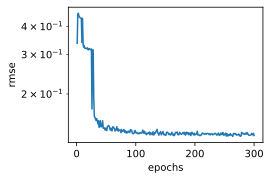

In [42]:
semilogy(range(1, num_epochs + 1), train_hist, 'epochs', 'rmse')

In [37]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = nd.concat(X_train, X_part, dim=0)
            y_train = nd.concat(y_train, y_part, dim=0)
    return X_train, y_train, X_valid, y_valid


def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay, batch_size):
    """
    选择最佳的参数组合
    :return 平均训练误差, 平均验证误差
    """
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        train_ls, valid_ls, params = train(net, *data, num_epochs, learning_rate, weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'rmse',
                         range(1, num_epochs + 1), valid_ls,
                         ['train', 'valid'])
        print('fold %d, train rmse %f, valid rmse %f'
              % (i, train_ls[-1], valid_ls[-1]))
    return train_l_sum / k, valid_l_sum / k

fold 0, train rmse 0.161776, valid rmse 0.146869
fold 1, train rmse 0.148121, valid rmse 0.205160
fold 2, train rmse 0.133614, valid rmse 0.149949
fold 3, train rmse 0.182864, valid rmse 0.173317
fold 4, train rmse 0.133960, valid rmse 0.160919


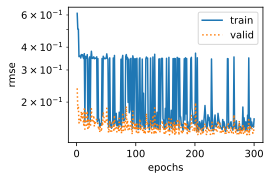

In [55]:
train_l, valid_l = k_fold(k, train_X, train_y, num_epochs, 0.052, 0.2, batch_size)

fold 0, train rmse 0.133232, valid rmse 0.165675
fold 1, train rmse 0.126924, valid rmse 0.156751
fold 2, train rmse 0.129296, valid rmse 0.156413
fold 3, train rmse 0.134696, valid rmse 0.141540
fold 4, train rmse 0.121033, valid rmse 0.161992
Learning Rate: 0.016, Weight Decay: 0, avg train rmse: 0.12903615832328796, avg valid rmse: 0.1564742624759674
fold 0, train rmse 0.133901, valid rmse 0.162126
fold 1, train rmse 0.127264, valid rmse 0.153855
fold 2, train rmse 0.128706, valid rmse 0.154690
fold 3, train rmse 0.134622, valid rmse 0.139417
fold 4, train rmse 0.119701, valid rmse 0.159698
Learning Rate: 0.016, Weight Decay: 0.01, avg train rmse: 0.12883884459733963, avg valid rmse: 0.15395710468292237
fold 0, train rmse 0.134964, valid rmse 0.161131
fold 1, train rmse 0.127547, valid rmse 0.151964
fold 2, train rmse 0.129009, valid rmse 0.153834
fold 3, train rmse 0.136032, valid rmse 0.139697
fold 4, train rmse 0.123276, valid rmse 0.160999
Learning Rate: 0.016, Weight Decay: 0.0

fold 0, train rmse 0.134154, valid rmse 0.152865
fold 1, train rmse 0.129913, valid rmse 0.154349
fold 2, train rmse 0.128924, valid rmse 0.152974
fold 3, train rmse 0.136785, valid rmse 0.138546
fold 4, train rmse 0.121457, valid rmse 0.158189
Learning Rate: 0.024, Weight Decay: 0.04, avg train rmse: 0.13024674952030182, avg valid rmse: 0.15138449668884277
fold 0, train rmse 0.143015, valid rmse 0.148196
fold 1, train rmse 0.131313, valid rmse 0.156643
fold 2, train rmse 0.132391, valid rmse 0.154490
fold 3, train rmse 0.138238, valid rmse 0.134261
fold 4, train rmse 0.133044, valid rmse 0.162350
Learning Rate: 0.024, Weight Decay: 0.08, avg train rmse: 0.13560035228729247, avg valid rmse: 0.1511881858110428
fold 0, train rmse 0.148274, valid rmse 0.148121
fold 1, train rmse 0.132845, valid rmse 0.163215
fold 2, train rmse 0.136398, valid rmse 0.155702
fold 3, train rmse 0.141228, valid rmse 0.135015
fold 4, train rmse 0.129202, valid rmse 0.159738
Learning Rate: 0.024, Weight Decay: 

fold 0, train rmse 0.138148, valid rmse 0.136233
fold 1, train rmse 0.137480, valid rmse 0.194283
fold 2, train rmse 0.135082, valid rmse 0.154517
fold 3, train rmse 0.145516, valid rmse 0.138991
fold 4, train rmse 0.136745, valid rmse 0.162969
Learning Rate: 0.032, Weight Decay: 0.12, avg train rmse: 0.13859420120716096, avg valid rmse: 0.1573985755443573
fold 0, train rmse 0.137878, valid rmse 0.136335
fold 1, train rmse 0.145192, valid rmse 0.637930
fold 2, train rmse 0.139299, valid rmse 0.155178
fold 3, train rmse 0.137407, valid rmse 0.128616
fold 4, train rmse 0.138074, valid rmse 0.162728
Learning Rate: 0.032, Weight Decay: 0.14, avg train rmse: 0.1395700454711914, avg valid rmse: 0.24415742456912995
fold 0, train rmse 0.152623, valid rmse 0.144188
fold 1, train rmse 0.136909, valid rmse 0.191364
fold 2, train rmse 0.145166, valid rmse 0.156129
fold 3, train rmse 0.152124, valid rmse 0.141881
fold 4, train rmse 0.136983, valid rmse 0.161861
Learning Rate: 0.032, Weight Decay: 0

fold 0, train rmse 0.152015, valid rmse 0.138522
fold 1, train rmse 0.137832, valid rmse 0.199688
fold 2, train rmse 0.141815, valid rmse 0.155210
fold 3, train rmse 0.156398, valid rmse 0.146923
fold 4, train rmse 0.145762, valid rmse 0.164837
Learning Rate: 0.04, Weight Decay: 0.2, avg train rmse: 0.14676434099674224, avg valid rmse: 0.16103609502315522
fold 0, train rmse 0.132874, valid rmse 0.188448
fold 1, train rmse 0.122369, valid rmse 0.163991
fold 2, train rmse 0.126495, valid rmse 0.160992
fold 3, train rmse 0.129579, valid rmse 0.147611
fold 4, train rmse 0.118707, valid rmse 0.164235
Learning Rate: 0.044, Weight Decay: 0, avg train rmse: 0.12600465416908263, avg valid rmse: 0.16505537033081055
fold 0, train rmse 0.129947, valid rmse 0.165167
fold 1, train rmse 0.123270, valid rmse 0.156323
fold 2, train rmse 0.129913, valid rmse 0.159431
fold 3, train rmse 0.132313, valid rmse 0.142694
fold 4, train rmse 0.116460, valid rmse 0.159321
Learning Rate: 0.044, Weight Decay: 0.01

fold 0, train rmse 0.136293, valid rmse 0.168027
fold 1, train rmse 0.127672, valid rmse 0.155223
fold 2, train rmse 0.132827, valid rmse 0.160924
fold 3, train rmse 0.133332, valid rmse 0.138111
fold 4, train rmse 0.120819, valid rmse 0.160236
Learning Rate: 0.052, Weight Decay: 0.02, avg train rmse: 0.13018860220909118, avg valid rmse: 0.1565042406320572
fold 0, train rmse 0.131946, valid rmse 0.141624
fold 1, train rmse 0.131770, valid rmse 0.154272
fold 2, train rmse 0.127765, valid rmse 0.149973
fold 3, train rmse 0.150139, valid rmse 0.157544
fold 4, train rmse 0.120128, valid rmse 0.158097
Learning Rate: 0.052, Weight Decay: 0.04, avg train rmse: 0.13234947770833969, avg valid rmse: 0.15230190753936768
fold 0, train rmse 0.139051, valid rmse 0.150103
fold 1, train rmse 0.135805, valid rmse 0.165768
fold 2, train rmse 0.133092, valid rmse 0.151744
fold 3, train rmse 0.137044, valid rmse 0.134461
fold 4, train rmse 0.124892, valid rmse 0.158172
Learning Rate: 0.052, Weight Decay: 

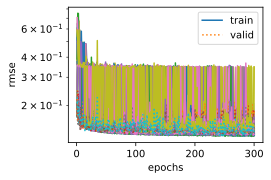

In [45]:
lr_tunning = [0.016, 0.02, 0.024, 0.028, 0.032, 0.036, 0.04, 0.044, 0.048, 0.052]  # 0.02 ~ 0.05, 不能太大
wd_tunning = [0, 0.01, 0.02, 0.04, 0.08, 0.1, 0.12, 0.14, 0.16, 0.2]  # 0 ~ 0.2
train_results = nd.zeros((len(lr_tunning), len(wd_tunning)))
valid_results = nd.zeros((len(lr_tunning), len(wd_tunning)))
for i, try_lr in enumerate(lr_tunning):
    for j, try_wd in enumerate(wd_tunning):
        train_l, valid_l = k_fold(k, train_X, train_y, num_epochs, try_lr, try_wd, batch_size)
        train_results[i][j] = train_l
        valid_results[i][j] = valid_l
        print('Learning Rate: {}, Weight Decay: {}, avg train rmse: {}, avg valid rmse: {}'.format(
            try_lr, try_wd, train_l, valid_l))

In [54]:
for i in range(len(lr_tunning)):
    for j in range(len(wd_tunning)):
        if valid_results[i][j] < 0.15:
            print(lr_tunning[i], ", ", wd_tunning[j], ", ", valid_results[i][j].asscalar())

0.04 ,  0.08 ,  0.14858097
0.044 ,  0.1 ,  0.1492438
0.048 ,  0.08 ,  0.14905143
0.052 ,  0.14 ,  0.14993387
0.052 ,  0.2 ,  0.14801782


In [ ]:
lr_tunning = [0.036, 0.04, 0.044, 0.048, 0.052, 0.056, 0.06, 0.064]  # 0.36 ~ 0.64, 限制范围
wd_tunning = [0.04, 0.08, 0.1, 0.12, 0.14, 0.16, 0.2, 0.24, 0.28, 0.32]  # 0.04 ~ 0.32
train_results = nd.zeros((len(lr_tunning), len(wd_tunning)))
valid_results = nd.zeros((len(lr_tunning), len(wd_tunning)))
for i, try_lr in enumerate(lr_tunning):
    for j, try_wd in enumerate(wd_tunning):
        train_l, valid_l = k_fold(k, train_X, train_y, num_epochs, try_lr, try_wd, batch_size)
        train_results[i][j] = train_l
        valid_results[i][j] = valid_l
        print('Learning Rate: {}, Weight Decay: {}, avg train rmse: {}, avg valid rmse: {}'.format(
            try_lr, try_wd, train_l, valid_l))

fold 0, train rmse 0.133529, valid rmse 0.151959
fold 1, train rmse 0.134723, valid rmse 0.160850
fold 2, train rmse 0.127959, valid rmse 0.151252
fold 3, train rmse 0.133260, valid rmse 0.134658
fold 4, train rmse 0.121535, valid rmse 0.158796
Learning Rate: 0.036, Weight Decay: 0.04, avg train rmse: 0.1302011415362358, avg valid rmse: 0.15150298178195953
fold 0, train rmse 0.150604, valid rmse 0.155937
fold 1, train rmse 0.137906, valid rmse 0.176366
fold 2, train rmse 0.130759, valid rmse 0.151670
fold 3, train rmse 0.142313, valid rmse 0.139593
fold 4, train rmse 0.130088, valid rmse 0.161315
Learning Rate: 0.036, Weight Decay: 0.08, avg train rmse: 0.13833411633968354, avg valid rmse: 0.15697609186172484
fold 0, train rmse 0.137922, valid rmse 0.139938
fold 1, train rmse 0.138712, valid rmse 0.180502
fold 2, train rmse 0.143151, valid rmse 0.159647
fold 3, train rmse 0.137294, valid rmse 0.132011
fold 4, train rmse 0.135557, valid rmse 0.163014
Learning Rate: 0.036, Weight Decay: 

fold 0, train rmse 0.141666, valid rmse 0.145071
fold 1, train rmse 0.133676, valid rmse 0.166497
fold 2, train rmse 0.137834, valid rmse 0.153792
fold 3, train rmse 0.136916, valid rmse 0.130122
fold 4, train rmse 0.133350, valid rmse 0.162197
Learning Rate: 0.044, Weight Decay: 0.12, avg train rmse: 0.13668835759162903, avg valid rmse: 0.15153583586215974
fold 0, train rmse 0.143261, valid rmse 0.142795
fold 1, train rmse 0.138987, valid rmse 0.194665
fold 2, train rmse 0.143919, valid rmse 0.159858
fold 3, train rmse 0.142869, valid rmse 0.137277
fold 4, train rmse 0.128022, valid rmse 0.158283
Learning Rate: 0.044, Weight Decay: 0.14, avg train rmse: 0.1394117295742035, avg valid rmse: 0.15857550501823425
fold 0, train rmse 0.154814, valid rmse 0.143210
fold 1, train rmse 0.130502, valid rmse 0.152007
fold 2, train rmse 0.136354, valid rmse 0.151281
fold 3, train rmse 0.144407, valid rmse 0.137259
fold 4, train rmse 0.130800, valid rmse 0.158911
Learning Rate: 0.044, Weight Decay: 

fold 0, train rmse 0.140502, valid rmse 0.133137
fold 1, train rmse 0.135537, valid rmse 0.154308
fold 2, train rmse 0.144681, valid rmse 0.154288
fold 3, train rmse 0.155590, valid rmse 0.149709
fold 4, train rmse 0.134669, valid rmse 0.165314
Learning Rate: 0.052, Weight Decay: 0.2, avg train rmse: 0.14219574630260468, avg valid rmse: 0.15135128498077394
fold 0, train rmse 0.167326, valid rmse 0.142587
fold 1, train rmse 0.135175, valid rmse 0.154775
fold 2, train rmse 0.139881, valid rmse 0.151168
fold 3, train rmse 0.157703, valid rmse 0.147568
fold 4, train rmse 0.148541, valid rmse 0.166284
Learning Rate: 0.052, Weight Decay: 0.24, avg train rmse: 0.14972528219223022, avg valid rmse: 0.15247629284858705
fold 0, train rmse 0.141103, valid rmse 0.130952
fold 1, train rmse 0.141748, valid rmse 0.164495
fold 2, train rmse 0.140256, valid rmse 0.151055
fold 3, train rmse 0.346555, valid rmse 0.166863
fold 4, train rmse 0.143311, valid rmse 0.169578
Learning Rate: 0.052, Weight Decay: 

### 改进
- 是不是可以考虑eary stopping
- 还是会有很大的波动
- 是不是可以考虑加隐藏层
- 还是有改进的策略的